# Resnet

## Please watch Ng C4W2L01-C4W2L04, the first of which is found [here](https://www.youtube.com/watch?v=-bvTzZCEOdM&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&index=12).

The convolutional neural network that we developed and ran was adequate for use on a small problem with a few classes, but it lacks the explanatory power to produce highly accurate results for more difficult datasets.  Instead, more interesting neural networks have been developed which have greater explanatory power.  One of the most powerful architectures today is called ResNet, which is short for residual network.  

In principle, you could take the network that you've been working on and make it more flexible by adding more convolutional layers, which is to say that we could add more sequences of feature map generation.  This is what is meant when people use the term "deep" learning.  However, if you did this, you would quickly run into the problem that your network would struggle to learn weights in the lower (closer to the inputs) layers of the network.  This is a result of the way that neural networks are trained.  In particular they rely on the ability to take the derivative of a misfit function (e.g. least squares) with respect to a parameter, and to adjust the weight based on that derivative.  However in (naive) deep networks, this gradient has the tendency to become negligibly small as the impact of that weight gets lost in the myriad layers of convolutions and activations closer to the output.  

ResNet solves this problem by ensuring that the information in each weight gets propagated to the output.  It does this by simply adding the layer's input to each layer's output, so instead of 
$$
\mathbf{x}_{l+1} = \mathcal{F}_{l}(\mathbf{x}_l),
$$
at each layer, the neural network performs the operation
$$
\mathbf{x}_{l+1} = \mathcal{F}_{l}(\mathbf{x}_l) + \mathbf{x}_l.
$$
Rearranging this equation, we can see why this architecture is called a residual network:
$$
\mathbf{x}_{l+1} - \mathbf{x}_l = \mathcal{F}_{l}(\mathbf{x}_l).
$$
Each layer is modeling the residual between consecutive feature maps.  The pedantic amongst us will note that this only works when the output of $\mathcal{F}_{l}(\mathbf{x}_l)$ is the same size as the input.  This is dealt with by performing a suitable linear transformation on $\mathbf{x}_l$, making the equation
$$
\mathbf{x}_{l+1} = \mathcal{F}_{l}(\mathbf{x}_l) + W \mathbf{x}_l,
$$
where $W$ is a matrix that has learnable weights.  The matrix $W$ is most often formulated as a convolution with a 1x1 kernel size.   

The addition of the input is known as a *skip connection* because it looks like this:
<img src=res_net.svg width=600/>
The input is run through a normal conv layer (perhaps several) and then added to the output, where it can then be maxpooled or run through an activation or whatever.  

Keras makes these sorts of networks pretty easy to program.  To start with, let's apply this network to the CIFAR-10 classification problem, but we'll do it for all 10 classes.  All the non-model definition code should look the same as our previous example.   

In [1]:
import keras
import keras.datasets as kd

(x_train, y_train), (x_test, y_test) = kd.cifar10.load_data()
labels = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

x_train = x_train/255.
x_test = x_test/255.

# Convert class vectors to binary class matrices.
N = len(labels)

y_train = keras.utils.to_categorical(y_train, N)
y_test = keras.utils.to_categorical(y_test, N)

Using TensorFlow backend.


Now things get more interesting.  Obviously, ResNet as described above is more of a concept than a specific architecture: we'll need to make some more specific design choices.  One good way of doing this is to look at the literature and copy what others have done.  In particular, the [original ResNet Paper](https://arxiv.org/abs/1512.03385) provides an example of ResNet being applied to CIFAR-10 that yielded excellent accuracy (state of the art c. 2015).  Here, we'll emulate their network architecture, which looks like this:
<img src=cifar_10_res_net.svg width=900/>
More concretely, the layers of this network up to (and including) the location of the star in the figure above, look like this.

In [21]:
import keras.layers as kl
import keras.regularizers as kr
import keras.models as km


def create_resnet_model(weights_file=None, cam_out=False):
    # Note the alternative method for model specification: no model.add(.), instead we 
    # perform sequential operations on layers, then we will make the resulting model later.

    # Specify the shape of the input image
    input_shape = x_train.shape[1:]
    inputs = kl.Input(shape=input_shape)

    # First convolution + BN + act
    conv = kl.Conv2D(16,(3,3),padding='same',kernel_regularizer=kr.l2(1e-4))(inputs)
    bn = kl.BatchNormalization()(conv)
    act1 = kl.Activation('relu')(bn)

    # Perform 3 convolution blocks
    for i in range(3):
        conv = kl.Conv2D(16,(3,3),padding='same',kernel_regularizer=kr.l2(1e-4))(act1)
        bn = kl.BatchNormalization()(conv)
        act = kl.Activation('relu')(bn)

        conv = kl.Conv2D(16,(3,3),padding='same',kernel_regularizer=kr.l2(1e-4))(act)
        bn = kl.BatchNormalization()(conv)

        # Skip layer addition
        skip = kl.add([act1,bn])
        act1 = kl.Activation('relu')(skip)  

    # Downsampling with strided convolution
    conv = kl.Conv2D(32,(3,3),padding='same',strides=2,kernel_regularizer=kr.l2(1e-4))(act1)
    bn = kl.BatchNormalization()(conv)
    act = kl.Activation('relu')(bn)
    conv = kl.Conv2D(32,(3,3),padding='same',kernel_regularizer=kr.l2(1e-4))(act)
    bn = kl.BatchNormalization()(conv)

    # Downsampling with strided 1x1 convolution
    act1_downsampled = kl.Conv2D(32,(1,1),padding='same',strides=2,kernel_regularizer=kr.l2(1e-4))(act1)
    # Downsampling skip layer
    skip_downsampled = kl.add([act1_downsampled,bn])
    act1 = kl.Activation('relu')(skip_downsampled)

    # This final layer is denoted by a star in the above figure
    for _ in range(2):
        conv = kl.Conv2D(32, (3, 3), padding="same", kernel_regularizer=kr.l2(1e-4))(act1)
        bn = kl.BatchNormalization()(conv)
        act = kl.Activation('relu')(bn)

        conv = kl.Conv2D(32, (3,3), padding='same', kernel_regularizer=kr.l2(1e-4))(act)
        bn = kl.BatchNormalization()(conv)

        # Skip layer addition
        skip = kl.add([act1,bn])
        act1 = kl.Activation('relu')(skip)

    # Downsampling with strided convolution
    conv = kl.Conv2D(64, (3,3), padding='same', strides=2, kernel_regularizer=kr.l2(1e-4))(act1)
    bn = kl.BatchNormalization()(conv)
    act = kl.Activation('relu')(bn)
    conv = kl.Conv2D(64, (3,3), padding='same', kernel_regularizer=kr.l2(1e-4))(act)
    bn = kl.BatchNormalization()(conv)

    # Downsampling with strided 1x1 convolution
    act1_downsampled = kl.Conv2D(64,(1,1),padding='same',strides=2,kernel_regularizer=kr.l2(1e-4))(act1)
    # Downsampling skip layer
    skip_downsampled = kl.add([act1_downsampled,bn])
    act1 = kl.Activation('relu')(skip_downsampled)

    # This final layer is denoted by a star in the above figure
    for _ in range(2):
        conv = kl.Conv2D(64, (3, 3), padding="same", kernel_regularizer=kr.l2(1e-4))(act1)
        bn = kl.BatchNormalization()(conv)
        act = kl.Activation('relu')(bn)
        conv = kl.Conv2D(64, (3,3), padding='same', kernel_regularizer=kr.l2(1e-4))(act)
        bn = kl.BatchNormalization()(conv)

        # Skip layer addition
        skip = kl.add([act1,bn])
        act1 = kl.Activation('relu')(skip)
    
    gap = kl.GlobalAveragePooling2D()(act1)
    bn = kl.BatchNormalization()(gap)
    final_dense = kl.Dense(N)
    fdtensor = final_dense(bn)
    softmax = kl.Activation('softmax')(fdtensor)
    
    if cam_out:
        # Output final conv layer's feature maps along with prediction
        model = km.Model(inputs=inputs, outputs=(act1, softmax))
    else:
        model = km.Model(inputs=inputs,outputs=softmax)
    # initiate adam optimizer
    opt = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    
    if weights_file is not None:
        model.load_weights(weights_file)
    return model, final_dense

To ensure that we have the output shape that we expect at this stage, we can look at the shape of act1  

Which is an object of size 16x16x32, the correct size based on our chosen architecture (note the first question mark indicates an unknown number of input images: thus if we ran the model on a single photo, this would be a 1, if we ran it on the entire CIFAR training set at once it would be 50000).  As before, we can use this model for classification by doing global average pooling, then the softmax function.

In [7]:
model, final_dense = create_resnet_model()

While the code as is works, it is *not* the complete architecture given in the figure above.  **Implement the remainder of the network, and train the model for 100 epochs.** The complete architecture has quite a few parameters, so you'll definitely want to use a GPU, i.e. run it on the cluster (reference the job script included in this repo).

There are also a few extra tidbits to make this work better.  First, we'll want to checkpoint the model, which is to say that we'll want to save the weights anytime the model improves during the training process.  We can do this easily in Keras with a checkpoint function:

In [6]:
import keras.callbacks as kc
filepath = './checkpoints'

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = kc.ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

Note that these weights can then be loaded into a model on your local machine for more convenient post-processing and visualization of results.  We'll also want to reduce the learning rate as the model reaches an optimal solution.  We can do this with a *learning rate schedule*.


In [7]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 60:
        lr *= 1e-1
    elif epoch > 120:
        lr *= 1e-2
    print('Learning rate: ', lr)
    return lr
lr_scheduler = kc.LearningRateScheduler(lr_schedule)

We can include these two functions as *callbacks* to the optimizer:

In [8]:
model.fit(x_train, y_train,
          batch_size=128,
          epochs=100,
          validation_data=(x_test, y_test),
          shuffle=True,
          callbacks=[checkpoint,lr_scheduler])

Instructions for updating:
Use tf.cast instead.
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
Learning rate:  0.001
50000/50000 [==============================] - 18s 362us/step - loss: 1.4424 - acc: 0.5059 - val_loss: 3.3213 - val_acc: 0.3090

Epoch 00001: val_acc improved from -inf to 0.30900, saving model to ./checkpoints
Epoch 2/100
Learning rate:  0.001
50000/50000 [==============================] - 14s 288us/step - loss: 0.9880 - acc: 0.6802 - val_loss: 1.8565 - val_acc: 0.4691

Epoch 00002: val_acc improved from 0.30900 to 0.46910, saving model to ./checkpoints
Epoch 3/100
Learning rate:  0.001
50000/50000 [==============================] - 14s 286us/step - loss: 0.8072 - acc: 0.7450 - val_loss: 1.2549 - val_acc: 0.6275

Epoch 00003: val_acc improved from 0.46910 to 0.62750, saving model to ./checkpoints
Epoch 4/100
Learning rate:  0.001
50000/50000 [==============================] - 15s 292us/step - loss: 0.7027 - acc: 0.7836 - val_loss: 1.0991 - val_acc: 0.6674

50000/50000 [==============================] - 14s 288us/step - loss: 0.0637 - acc: 1.0000 - val_loss: 1.2863 - val_acc: 0.8149

Epoch 00074: val_acc did not improve from 0.82130
Epoch 75/100
Learning rate:  0.0001
50000/50000 [==============================] - 14s 289us/step - loss: 0.0594 - acc: 1.0000 - val_loss: 1.2768 - val_acc: 0.8125

Epoch 00075: val_acc did not improve from 0.82130
Epoch 76/100
Learning rate:  0.0001
50000/50000 [==============================] - 15s 296us/step - loss: 0.0558 - acc: 1.0000 - val_loss: 1.2725 - val_acc: 0.8183

Epoch 00076: val_acc did not improve from 0.82130
Epoch 77/100
Learning rate:  0.0001
50000/50000 [==============================] - 14s 287us/step - loss: 0.0526 - acc: 1.0000 - val_loss: 1.3324 - val_acc: 0.8129

Epoch 00077: val_acc did not improve from 0.82130
Epoch 78/100
Learning rate:  0.0001
50000/50000 [==============================] - 14s 288us/step - loss: 0.0500 - acc: 0.9999 - val_loss: 1.3400 - val_acc: 0.8164

Epoch 00078

Once your model is fitted, **adapt your class activation mapping routine to run on this more advanced architecture, and compute a few examples?  How do these activation maps differ from those computed for the smaller network?**

## Data augmentation

Data augmentation relies on the idea that the semantic content of an image remains the same regardless of small variations.  For example, a dog is still a dog even after rotating an image by 20 degrees, or flipping across its axis, or zooming in or out a little bit.  By applying these operations to our training examples, the network can never rely on a single pixel's value, thus reducing the possibility of [overfitting](https://en.wikipedia.org/wiki/Overfitting), and also enhances the generalizability of the network.   

In [11]:
from keras.preprocessing.image import ImageDataGenerator

filepath = './checkpoints_aug'

# Prepare callbacks for model saving and for learning rate adjustment.
cp_aug = kc.ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    zca_epsilon=1e-06,  # epsilon for ZCA whitening
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    # randomly shift images horizontally (fraction of total width)
    width_shift_range=0.1,
    # randomly shift images vertically (fraction of total height)
    height_shift_range=0.1,
    shear_range=0.01,  # set range for random shear
    zoom_range=0.2,  # set range for random zoom
    channel_shift_range=0.,  # set range for random channel shifts
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    cval=0.,  # value used for fill_mode = "constant"
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,  # randomly flip images
    # set rescaling factor (applied before any other transformation)
    rescale=None,
    # set function that will be applied on each input
    preprocessing_function=None,
    # image data format, either "channels_first" or "channels_last"
    data_format=None,
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0.0)

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

batch_size = 64
epochs = 180

# Fit the model on the batches generated bydatagen.flow().
model.fit_generator(
    datagen.flow(
        x_train, y_train,
        batch_size=batch_size
    ),
    steps_per_epoch=len(x_train)/batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),verbose=1, workers=4,
    callbacks=[cp_aug, lr_scheduler]
)

Epoch 1/180
Learning rate:  0.001
782/781 [==============================] - 22s 28ms/step - loss: 0.5149 - acc: 0.8725 - val_loss: 0.8352 - val_acc: 0.7962

Epoch 00001: val_acc improved from -inf to 0.79620, saving model to ./checkpoints_aug
Epoch 2/180
Learning rate:  0.001
782/781 [==============================] - 21s 27ms/step - loss: 0.5081 - acc: 0.8735 - val_loss: 0.6996 - val_acc: 0.8305

Epoch 00002: val_acc improved from 0.79620 to 0.83050, saving model to ./checkpoints_aug
Epoch 3/180
Learning rate:  0.001
782/781 [==============================] - 21s 27ms/step - loss: 0.4989 - acc: 0.8780 - val_loss: 0.9221 - val_acc: 0.7808

Epoch 00003: val_acc did not improve from 0.83050
Epoch 4/180
Learning rate:  0.001
782/781 [==============================] - 21s 27ms/step - loss: 0.4969 - acc: 0.8779 - val_loss: 0.8228 - val_acc: 0.8015

Epoch 00004: val_acc did not improve from 0.83050
Epoch 5/180
Learning rate:  0.001
782/781 [==============================] - 21s 27ms/step - 

782/781 [==============================] - 21s 27ms/step - loss: 0.4349 - acc: 0.9023 - val_loss: 0.5560 - val_acc: 0.8700

Epoch 00039: val_acc improved from 0.86360 to 0.87000, saving model to ./checkpoints_aug
Epoch 40/180
Learning rate:  0.001
782/781 [==============================] - 21s 27ms/step - loss: 0.4342 - acc: 0.9034 - val_loss: 0.8191 - val_acc: 0.8057

Epoch 00040: val_acc did not improve from 0.87000
Epoch 41/180
Learning rate:  0.001
782/781 [==============================] - 21s 27ms/step - loss: 0.4318 - acc: 0.9036 - val_loss: 0.5543 - val_acc: 0.8705

Epoch 00041: val_acc improved from 0.87000 to 0.87050, saving model to ./checkpoints_aug
Epoch 42/180
Learning rate:  0.001
782/781 [==============================] - 21s 27ms/step - loss: 0.4371 - acc: 0.9029 - val_loss: 0.6518 - val_acc: 0.8483

Epoch 00042: val_acc did not improve from 0.87050
Epoch 43/180
Learning rate:  0.001
782/781 [==============================] - 21s 27ms/step - loss: 0.4375 - acc: 0.9029 


Epoch 00115: val_acc did not improve from 0.91020
Epoch 116/180
Learning rate:  0.0001
782/781 [==============================] - 21s 27ms/step - loss: 0.2144 - acc: 0.9650 - val_loss: 0.4643 - val_acc: 0.9078

Epoch 00116: val_acc did not improve from 0.91020
Epoch 117/180
Learning rate:  0.0001
782/781 [==============================] - 21s 27ms/step - loss: 0.2116 - acc: 0.9658 - val_loss: 0.4564 - val_acc: 0.9084

Epoch 00117: val_acc did not improve from 0.91020
Epoch 118/180
Learning rate:  0.0001
782/781 [==============================] - 21s 27ms/step - loss: 0.2120 - acc: 0.9660 - val_loss: 0.4390 - val_acc: 0.9104

Epoch 00118: val_acc improved from 0.91020 to 0.91040, saving model to ./checkpoints_aug
Epoch 119/180
Learning rate:  0.0001
782/781 [==============================] - 21s 27ms/step - loss: 0.2128 - acc: 0.9655 - val_loss: 0.4619 - val_acc: 0.9078

Epoch 00119: val_acc did not improve from 0.91040
Epoch 120/180
Learning rate:  0.0001
782/781 [====================

782/781 [==============================] - 21s 27ms/step - loss: 0.1813 - acc: 0.9703 - val_loss: 0.4680 - val_acc: 0.9053

Epoch 00154: val_acc did not improve from 0.91120
Epoch 155/180
Learning rate:  0.0001
782/781 [==============================] - 21s 27ms/step - loss: 0.1829 - acc: 0.9711 - val_loss: 0.4797 - val_acc: 0.9044

Epoch 00155: val_acc did not improve from 0.91120
Epoch 156/180
Learning rate:  0.0001
782/781 [==============================] - 21s 27ms/step - loss: 0.1829 - acc: 0.9703 - val_loss: 0.4828 - val_acc: 0.9076

Epoch 00156: val_acc did not improve from 0.91120
Epoch 157/180
Learning rate:  0.0001
782/781 [==============================] - 21s 27ms/step - loss: 0.1827 - acc: 0.9703 - val_loss: 0.4701 - val_acc: 0.9089

Epoch 00157: val_acc did not improve from 0.91120
Epoch 158/180
Learning rate:  0.0001
782/781 [==============================] - 21s 27ms/step - loss: 0.1813 - acc: 0.9708 - val_loss: 0.4807 - val_acc: 0.9061

Epoch 00158: val_acc did not imp

In [22]:
model, final_dense = create_resnet_model("./checkpoints_aug", True)

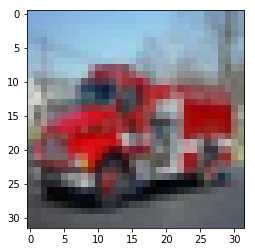

Probability of each class:  [[5.2181805e-12 3.4923646e-09 5.8861973e-14 5.5235118e-17 1.6152515e-18 5.3626699e-16
  3.2260173e-17 9.0423103e-17 6.0418017e-15 1.0000000e+00]]
This thing is a: truck


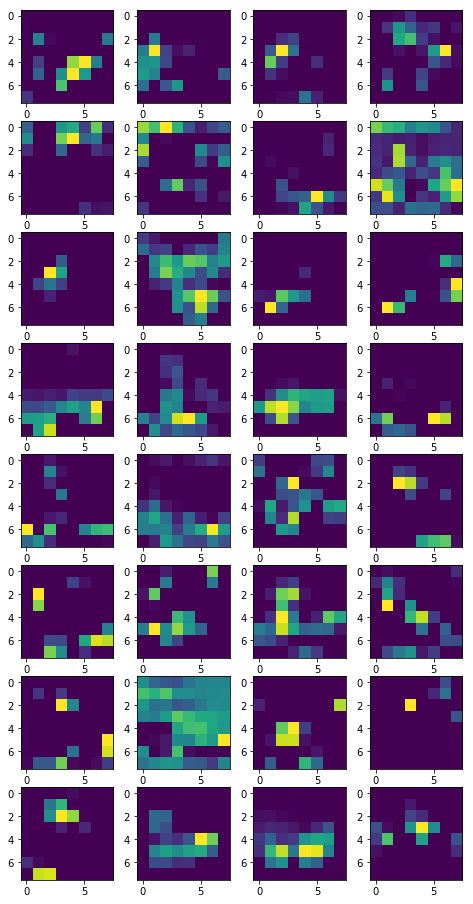

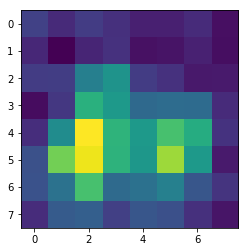

(8, 8) (32, 32)


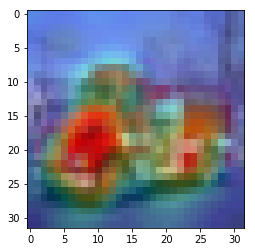

In [57]:
import matplotlib.pyplot as plt

idx = np.random.randint(0,len(x_train))
img = x_train[idx]
last_conv, probs = model.predict(img.reshape((1,32,32,3)))

plt.imshow(img)
plt.show()

fig,axs = plt.subplots(nrows=8,ncols=4,figsize=(8,16))
for j,r in enumerate(axs):
    for i,ax in enumerate(r):
        ax.imshow(last_conv[0,:,:,4*j + i])
        
print('Probability of each class: ',probs)

# Make a prediction by taking the argmax of the probabilities
pred = np.argmax(probs)
print('This thing is a: '+ labels[pred])
plt.show()

weights = final_dense.get_weights()[0][:,pred]
fmaps = np.array([last_conv[0, :, :, i] for i in range(last_conv.shape[3])])

cam = np.zeros(last_conv.shape[1:3])
for m, w in zip(fmaps, weights):
    cam += m * w
plt.imshow(cam)
plt.show()

import scipy.ndimage as snd
cam_upscaled = snd.zoom(cam, 4)
print(cam.shape, cam_upscaled.shape)

plt.imshow(x_train[idx])
plt.imshow(cam_upscaled, alpha=0.3, cmap=plt.cm.jet)